In [1]:
%matplotlib inline
import data
import builder
import pandas as pd

df = pd.DataFrame(data.build_dataset(10000))
df.head()

Using Theano backend.


,holder,holder_index,amount,dispute_risk,incidents,age,holder_risk
0,SILVER,1,159.14,3,0,43,0
1,GOLD,2,22.90,1,2,68,0
2,STANDARD,0,210.67,5,1,29,1
3,PLATINUM,3,152.57,2,0,69,0
4,STANDARD,0,125.68,3,0,24,2


## Dispute Risk (DR) model
Split the datasets:

In [2]:
from sklearn.model_selection import train_test_split

DR_outputs = df['dispute_risk']
DR_inputs = df[['amount', 'holder_index']]

DR_X_train, DR_X_test, DR_y_train, DR_y_test = train_test_split(DR_inputs, DR_outputs, test_size=0.4, random_state=23)

### Linear regression

In [3]:
DR_lr_pipeline = builder.build_LR_pipeline(DR_X_train, DR_y_train)

In [4]:
DR_lr_predictions = DR_lr_pipeline.predict(DR_X_test)
print(DR_lr_pipeline.score(DR_X_test, DR_y_test))

0.8109130506118416


### Random forest

In [5]:
DR_rf_pipeline = builder.build_RF_pipeline(DR_X_train, DR_y_train)

/Users/rcardoso/.condaenvs/risk-pmml-builder/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [6]:
DR_rf_predictions = DR_rf_pipeline.predict(DR_X_test)
print(DR_rf_pipeline.score(DR_X_test, DR_y_test))

0.9998735688698461


### ANN

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Activation
def create_model():
    model = Sequential()
    model.add(Dense(64, input_dim=2))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold

model = create_model()
model.fit(DR_X_train, DR_y_train, epochs=64, batch_size=8, verbose=1,
          validation_data=(DR_X_test, DR_y_test))

Train on 6000 samples, validate on 4000 samples
Epoch 1/64
6000/6000 [==============================] - 1s 90us/step - loss: 1.0289 - val_loss: 0.1861
Epoch 2/64
6000/6000 [==============================] - 0s 50us/step - loss: 0.2035 - val_loss: 0.1595
Epoch 3/64
6000/6000 [==============================] - 0s 64us/step - loss: 0.2129 - val_loss: 0.2085
Epoch 4/64
6000/6000 [==============================] - 0s 74us/step - loss: 0.2158 - val_loss: 0.1653
Epoch 5/64
6000/6000 [==============================] - 0s 55us/step - loss: 0.2250 - val_loss: 0.1593
Epoch 6/64
6000/6000 [==============================] - 0s 47us/step - loss: 0.2110 - val_loss: 0.1510
Epoch 7/64
6000/6000 [==============================] - 0s 47us/step - loss: 0.2236 - val_loss: 0.2770
Epoch 8/64
6000/6000 [==============================] - 0s 52us/step - loss: 0.2298 - val_loss: 0.1701
Epoch 9/64
6000/6000 [==============================] - 0s 53us/step - loss: 0.2117 - val_loss: 0.3212
Epoch 10/64
6000/6000 [==

In [8]:
DR_ann_predictiors = model.predict(DR_X_test, verbose=1)
print(DR_ann_predictiors)

4000/4000 [==============================] - 0s 2us/step
[[2.1083066]
 [1.6470735]
 [2.8334277]
 ...
 [2.7838342]
 [1.5119579]
 [0.8986132]]


### Comparison

In [10]:
DR_result = pd.DataFrame({'LR': DR_lr_predictions.astype(int), 
                          'RF': DR_rf_predictions.astype(int),
                          'ANN': [int(p[0]) for p in DR_ann_predictiors.tolist()],
                          'truth': DR_y_test})
DR_result.head(20)

,LR,RF,ANN,truth
6326,2,2,2,2
5185,1,2,1,2
2495,2,3,2,3
2765,2,2,2,2
9303,2,2,1,2
322,1,1,1,1
4164,3,3,3,3
7198,3,3,3,3
2626,1,1,1,1
4492,3,3,2,3


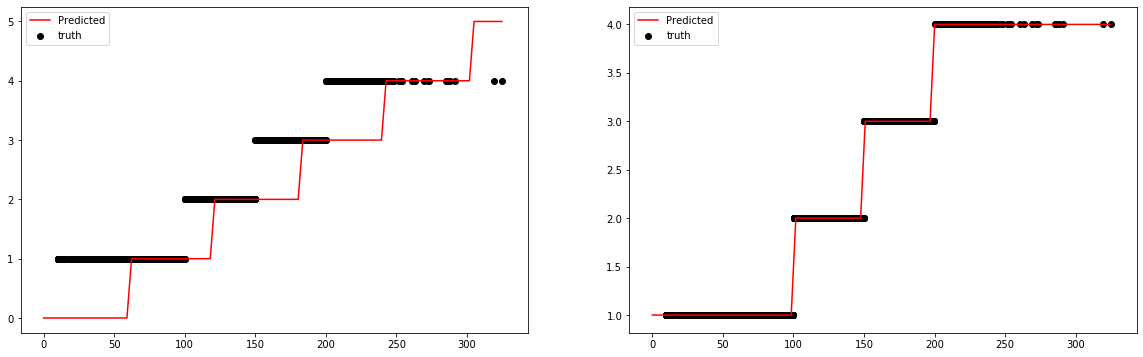

In [54]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,6)

holder_index = 2
testing = pd.DataFrame({'amount': np.linspace(0, DR_X_test['amount'].max(), 100), 'holder_index': holder_index})
sub_test = df[df['holder_index']==holder_index]

LR_predictions = DR_lr_pipeline.predict(testing).astype(int)
plt.subplot(121)
plt.plot(testing['amount'], LR_predictions, color='red', label='Predicted')
plt.scatter(sub_test['amount'], sub_test['dispute_risk'], color='black', label='truth')
plt.legend()
plt.subplot(122)
RF_predictions = DR_rf_pipeline.predict(testing).astype(int)
plt.plot(testing['amount'], RF_predictions, color='red', label='Predicted')
plt.scatter(sub_test['amount'], sub_test['dispute_risk'], color='black', label='truth')
plt.legend()

## Card Holder (CH) model

In [ ]:
CH_outputs = df['holder_risk']
CH_inputs = df[['age', 'holder_index', 'incidents']]

CH_X_train, CH_X_test, CH_y_train, CH_y_test = train_test_split(CH_inputs, CH_outputs, test_size=0.4, random_state=23)

### Linear regression

In [ ]:
CH_lr_pipeline = builder.build_LR_pipeline(CH_X_train, CH_y_train)

In [ ]:
CH_lr_predictions = CH_lr_pipeline.predict(CH_X_test)
print(CH_lr_pipeline.score(CH_X_test, CH_y_test))

### Random forest

In [ ]:
CH_rf_pipeline = builder.build_RF_pipeline(CH_X_train, CH_y_train)

In [ ]:
CH_rf_predictions = CH_rf_pipeline.predict(CH_X_test)
print(CH_rf_pipeline.score(CH_X_test, CH_y_test))

In [ ]:
CH_result = pd.DataFrame({'LR': CH_lr_predictions.astype(int), 'RF': CH_rf_predictions.astype(int), 'truth': CH_y_test})
CH_result.head(20)